In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle
from tqdm import tqdm
import csv

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import decoder functions
from Neural_Decoding.decoders import WienerFilterDecoder

In [12]:
# import the data
import os

path = '../preprocessed_data/special_ind_tar/'

R2 = np.empty((2,8))

for (col,filename) in enumerate(sorted(os.listdir(path))):
    if filename.endswith('.pickle'):
        
        with open(os.path.join(path, filename),'rb') as f:
            M1, PMd, M1_PMd,pos_binned,vels_binned=pickle.load(f,encoding='latin1') #If using python 3
            # group neural data and kinematics
            neural_data_combined = [M1]
            kinematics = [pos_binned, vels_binned]
            for (i, neural_data) in enumerate(neural_data_combined):
                for (j, output) in enumerate(kinematics):
                    # Preprocess data
                    bins_before=6 #How many bins of neural data prior to the output are used for decoding
                    bins_current=1 #Whether to use concurrent time bin of neural data
                    bins_after=0 #How many bins of neural data after the output are used for decoding

                    # Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
                    # Function to get the covariate matrix that includes spike history from previous bins
                    X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

                    # Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
                    #Put in "flat" format, so each "neuron / time" is a single feature
                    X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))
                
                    # Output covariates
                    #Set decoding output
                    y=output

                    # Split into training / testing / validation sets
                    #Set what part of data should be part of the training/testing/validation sets
                    training_range=[0, 0.7]
                    testing_range=[0.7, 0.85]
                    valid_range=[0.85,1]

                    # Split data:
                    num_examples=X.shape[0]

                    #Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
                    #This makes it so that the different sets don't include overlapping neural data
                    training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
                    testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
                    valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

                    #Get training data
                    X_train=X[training_set,:,:]
                    X_flat_train=X_flat[training_set,:]
                    y_train=y[training_set,:]

                    #Get testing data
                    X_test=X[testing_set,:,:]
                    X_flat_test=X_flat[testing_set,:]
                    y_test=y[testing_set,:]

                    #Get validation data
                    X_valid=X[valid_set,:,:]
                    X_flat_valid=X_flat[valid_set,:]
                    y_valid=y[valid_set,:]

                    # Process covariates
                    #Z-score "X" inputs. 
                    #X_train_mean=np.nanmean(X_train,axis=0)
                   # X_train_std=np.nanstd(X_train,axis=0)
                    #X_train=(X_train-X_train_mean)/X_train_std
                    #X_test=(X_test-X_train_mean)/X_train_std
                    #X_valid=(X_valid-X_train_mean)/X_train_std

                    #Z-score "X_flat" inputs. 
                    #X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
                   # X_flat_train_std=np.nanstd(X_flat_train,axis=0)
                    #X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
                    #X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
                    #X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

                    #Zero-center outputs
                   # y_train_mean=np.nanmean(y_train,axis=0)
                    #y_train=y_train-y_train_mean
                    #y_test=y_test-y_train_mean
                    #y_valid=y_valid-y_train_mean

                    # Run decoder
                    #Declare model
                    model_wf=WienerFilterDecoder()

                    #Fit model
                    model_wf.fit(X_flat_train,y_train)
                    
                    #Get predictions
                    y_valid_predicted_wf=model_wf.predict(X_flat_valid)

                    R2_vw = r2_score(y_valid,y_valid_predicted_wf, multioutput='variance_weighted')
                    R2[2*i+j,col] = R2_vw
            
            

In [15]:
# get average of R2 values for each kinematic
R2_mean = np.average(R2,axis=1)
R2_std = np.std(R2,axis=1)

# Export the data into a csv file for further analysis
#csv_rowlist = [['R^2 values','Wiener Filter', 'M1 data'], ['Target','1','2','3','4','5','6','7','8','Average', 'Std. dev.'], ['position',R2[0,0],R2[0,1],R2[0,2],R2[0,3],R2[0,4],R2[0,5],R2[0,6],R2[0,7],R2_mean[0],R2_std[0]], ['velocity',R2[1,0],R2[1,1],R2[1,2],R2[1,3],R2[1,4],R2[1,5],R2[1,6],R2[1,7],R2_mean[1],R2_std[1]]]

#export_path = '../Results/Ind_tar/WF_raw_RS_tar.csv'
#with open(export_path, 'w', newline='') as file:
   # writer = csv.writer(file)
    #writer.writerows(csv_rowlist)

In [16]:
print(R2)
print(R2_mean)

[[-1.19888398e+01 -8.08406659e+00 -5.03340337e+00 -5.03340337e+00
  -6.39472525e+00 -7.71511547e+00 -1.73590985e+00 -2.89699209e+00]
 [-6.11144018e-01 -4.02965816e+00  9.65528488e-03  9.65528488e-03
   5.54721709e-01  1.77582198e-01 -2.69472783e+00  2.19975904e-01]]
[-6.11030697 -0.79549245]


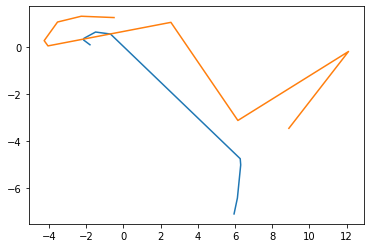

In [14]:
plt.plot(y_valid[1:10,0], y_valid[1:10,1])
plt.plot(y_valid_predicted_wf[1:10,0],y_valid_predicted_wf[1:10,1])